In [ ]:
%matplotlib inline


# A. Comparison of ensembling classifiers internally using sampling


Ensembling classifiers have shown to improve classification performance compare to single learner. However, they will be affected by class imbalance. This example shows the benefit of balancing the training set before to learn given learners. I am making the comparison with non-balanced ensemble methods.

I make a comparison using the balanced accuracy and geometric mean which are metrics widely used in the literature to evaluate models learned on imbalanced set.


In [ ]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

#from imblearn.datasets import fetch_datasets
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
import xgboost as xgb

from imblearn.metrics import geometric_mean_score

from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/

# 1. Load an imbalanced dataset

"In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder."


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro’s Safe Driver Prediction/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Final Project/Porto Seguro’s Safe Driver Prediction/test.csv')

In [ ]:
df_train.shape

(595212, 59)

In [ ]:
# y_train = df_train[['id', 'target']].set_index('id')
# X_train = df_train.drop(['target'], axis=1).set_index('id')
# X_test = df_test.set_index('id')

In [ ]:
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [ ]:
df_test.head(5)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


In [ ]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.impute import SimpleImputer

# def convert_float64(X):
#     return X.astype(np.float64)

In [ ]:
# numerical_columns = [name for name in X_train.columns
#                      if '_calc_' in name and '_bin' not in name]
# numerical_pipeline = make_pipeline(
#     FunctionTransformer(func=convert_float64, validate=False),
#     StandardScaler())

# categorical_columns = [name for name in X_train.columns
#                        if '_cat' in name]
# categorical_pipeline = make_pipeline(
#     SimpleImputer(missing_values=-1, strategy='most_frequent'),
#     OneHotEncoder(categories='auto'))

# preprocessor = ColumnTransformer(
#     [('numerical_preprocessing', numerical_pipeline, numerical_columns),
#      ('categorical_preprocessing', categorical_pipeline, categorical_columns)],
#     remainder='drop')

# # Create an environment variable to avoid using the GPU. This can be changed.
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# 2. Data Exploration

In [ ]:
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [ ]:
df_train.isnull()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
595208,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
595209,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
595210,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [ ]:
df_train.isna()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
595208,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
595209,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
595210,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [ ]:
# Determine if ANY Value in a Series is Missing
df_train.isnull().values.any()

False

In [ ]:
df_train.isnull().sum()

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0


In [ ]:
df_train.isna().sum()

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0


In [ ]:
df_train.describe

<bound method NDFrame.describe of              id  target  ...  ps_calc_19_bin  ps_calc_20_bin
0             7       0  ...               0               1
1             9       0  ...               1               0
2            13       0  ...               1               0
3            16       0  ...               0               0
4            17       0  ...               1               0
...         ...     ...  ...             ...             ...
595207  1488013       0  ...               1               1
595208  1488016       0  ...               1               1
595209  1488017       0  ...               0               0
595210  1488021       0  ...               0               0
595211  1488027       0  ...               0               0

[595212 rows x 59 columns]>

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [ ]:
df_test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


In [ ]:
labels = df_train.columns[2:]

X = df_train[labels]
y = df_train['target']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test ,y_test, test_size=.5, shuffle=True, random_state=0)
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_val:', y_val.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (476169, 57)
Shape of y_train: (476169,)
Shape of X_val: (59522, 57)
Shape of y_val: (59522,)
Shape of X_test: (59521, 57)
Shape of y_test: (59521,)


The data set is imbalanced.
Class 0: 573518
Class 1: 21694
Proportion: 26.44 : 1


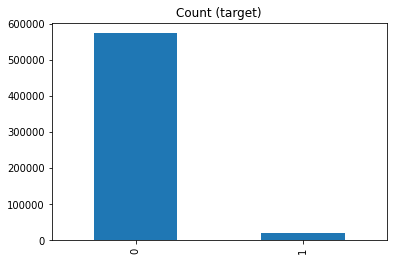

In [ ]:
target_count = df_train.target.value_counts()
print('The data set is imbalanced.')
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)');

In [ ]:
X_train.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
24433,2,1,2,1,0,0,0,0,1,0,0,0,0,0,10,0,1,0,0.1,0.2,-1.000000,6,1,-1,0,1,0,1,1,0,1,46,3,0.400000,0.694786,0.366333,3.000000,0.5,0.3,0.0,5,2,7,2,10,2,10,9,2,4,8,0,1,1,1,1,0
227637,1,1,5,0,0,1,0,0,0,0,0,0,0,0,8,0,1,0,0.9,0.7,0.557898,11,1,-1,0,-1,11,1,1,2,1,103,1,0.316228,0.598552,0.358329,3.000000,0.9,0.8,0.2,1,4,8,1,9,1,3,3,2,4,7,0,0,1,0,0,0
245461,0,1,6,0,0,0,1,0,0,0,0,0,0,0,5,1,0,0,0.2,0.2,-1.000000,11,1,-1,0,-1,1,1,1,2,1,31,3,0.374166,0.774517,0.385487,3.162278,0.0,0.0,0.3,4,2,6,2,10,1,8,5,1,5,11,0,0,1,1,0,0
325281,5,4,8,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.3,0.0,0.568990,7,1,1,2,0,11,1,1,2,1,94,0,0.374166,0.797284,0.330454,3.605551,0.3,0.8,0.9,1,1,8,1,11,4,8,4,2,1,7,0,1,1,0,1,0
378468,4,1,8,1,0,0,1,0,0,0,0,0,0,0,8,1,0,0,0.8,0.6,-1.000000,9,0,1,9,0,2,-1,1,0,1,104,3,0.447214,1.593679,0.466905,3.741657,0.3,0.1,0.9,3,4,5,2,9,1,5,8,3,5,8,1,1,0,1,0,0


In [ ]:
y_train.head()

24433     0
227637    0
245461    0
325281    0
378468    0
Name: target, dtype: int64

In [ ]:
X_val.head(5)

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
95674,4,2,3,0,0,0,0,0,1,0,0,0,0,0,11,1,0,0,0.9,1.3,1.397766,7,1,-1,0,-1,4,1,1,2,1,50,2,0.400000,0.650270,0.394335,2.828427,0.2,0.9,0.6,4,2,5,2,9,3,11,8,1,3,3,0,1,0,1,0,0
69998,1,1,1,0,0,0,0,1,0,0,0,0,0,0,10,0,0,0,0.8,0.4,0.881405,6,1,-1,0,0,1,1,0,0,1,70,2,0.400000,1.017930,0.396232,3.741657,0.8,0.9,0.4,1,3,10,3,12,3,12,10,3,5,8,0,1,1,1,0,0
501821,0,1,2,0,0,1,0,0,0,0,0,0,0,0,11,1,0,0,0.9,0.3,0.680074,11,1,-1,0,-1,7,1,1,2,1,92,3,0.374166,0.692522,0.392683,3.000000,0.9,0.1,0.3,4,1,7,3,10,1,4,6,0,1,11,0,0,1,0,1,0
153488,2,1,10,0,0,0,0,1,0,0,0,0,0,0,2,0,0,1,0.4,0.0,0.921276,5,1,-1,2,-1,1,0,1,0,1,104,0,0.360555,0.579737,0.410366,2.236068,0.4,0.7,0.3,4,1,7,2,11,1,6,11,3,0,9,0,0,0,0,0,0
539825,0,1,3,1,0,1,0,0,0,0,0,0,0,0,11,0,0,1,0.1,0.2,-1.000000,7,1,1,0,0,1,1,0,2,1,80,3,0.316228,0.842763,-1.000000,3.741657,0.1,0.7,0.8,3,3,9,3,8,3,11,5,1,4,6,0,0,0,0,0,0


In [ ]:
y_val.head()

95674     0
69998     0
501821    0
153488    0
539825    0
Name: target, dtype: int64

In [ ]:
X_test.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
261431,7,1,8,1,0,1,0,0,0,0,0,0,0,0,10,1,0,0,0.4,0.0,0.750000,7,1,0,0,1,1,1,1,2,1,70,3,0.374166,0.778455,0.339116,3.162278,0.3,0.8,0.4,2,1,8,6,10,2,13,6,0,3,6,0,1,0,0,0,0
35546,5,1,3,0,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,1.5,1.646967,11,0,0,0,1,10,1,1,2,1,89,2,0.387298,0.912063,0.336155,3.162278,0.7,0.6,0.2,4,1,8,5,9,0,5,5,2,1,5,1,0,1,0,0,0
569983,2,1,9,0,0,0,0,0,1,0,0,0,0,0,9,0,1,0,0.7,0.0,1.203900,11,0,1,0,0,11,1,1,2,1,3,2,0.424264,1.096891,0.378946,3.464102,0.6,0.9,0.2,3,2,7,7,11,4,6,5,1,2,4,0,1,1,0,0,0
20364,0,1,2,1,0,0,0,1,0,0,0,0,0,0,11,1,0,0,0.4,0.0,0.698659,11,1,0,0,0,0,1,1,2,1,95,2,0.400000,0.732129,0.334813,2.828427,0.2,0.9,0.3,0,2,6,3,10,3,10,7,3,0,10,0,0,1,0,0,1
151807,2,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0.0,0.3,0.596343,11,0,1,0,0,11,1,0,2,1,3,2,0.424264,1.192539,0.378946,3.605551,0.9,0.4,0.5,1,2,9,5,11,2,9,6,1,1,10,0,0,1,1,0,0


In [ ]:
y_test.head()

261431    0
35546     0
569983    0
20364     0
151807    0
Name: target, dtype: int64

## Unique values of each features

In [ ]:
print('ps_ind_01 unique values: ', df_train['ps_ind_01'].unique())
print('ps_ind_02_cat unique values: ', df_train['ps_ind_02_cat'].unique())
print('ps_ind_03 unique values: ', df_train['ps_ind_03'].unique())
print('ps_ind_04_cat unique values: ', df_train['ps_ind_04_cat'].unique())
print('ps_ind_05_cat unique values: ', df_train['ps_ind_05_cat'].unique())
print('ps_ind_06_bin unique values: ', df_train['ps_ind_06_bin'].unique())
print('ps_ind_07_bin unique values: ', df_train['ps_ind_07_bin'].unique())
print('ps_ind_08_bin unique values: ', df_train['ps_ind_08_bin'].unique())
print('ps_ind_09_bin unique values: ', df_train['ps_ind_09_bin'].unique())
print('ps_ind_10_bin unique values: ', df_train['ps_ind_10_bin'].unique())
print('ps_ind_11_bin unique values: ', df_train['ps_ind_11_bin'].unique())
print('ps_ind_12_bin unique values: ', df_train['ps_ind_12_bin'].unique())
print('ps_ind_13_bin unique values: ', df_train['ps_ind_13_bin'].unique())
print('ps_ind_14 unique values: ', df_train['ps_ind_14'].unique())
print('ps_ind_15 unique values: ', df_train['ps_ind_14'].unique())
print('ps_ind_16_bin unique values: ', df_train['ps_ind_16_bin'].unique())
print('ps_ind_17_bin unique values: ', df_train['ps_ind_17_bin'].unique())
print('ps_ind_18_bin unique values: ', df_train['ps_ind_18_bin'].unique())

ps_ind_01 unique values:  [2 1 5 0 4 3 6 7]
ps_ind_02_cat unique values:  [ 2  1  4  3 -1]
ps_ind_03 unique values:  [ 5  7  9  2  0  4  3  1 11  6  8 10]
ps_ind_04_cat unique values:  [ 1  0 -1]
ps_ind_05_cat unique values:  [ 0  1  4  3  6  5 -1  2]
ps_ind_06_bin unique values:  [0 1]
ps_ind_07_bin unique values:  [1 0]
ps_ind_08_bin unique values:  [0 1]
ps_ind_09_bin unique values:  [0 1]
ps_ind_10_bin unique values:  [0 1]
ps_ind_11_bin unique values:  [0 1]
ps_ind_12_bin unique values:  [0 1]
ps_ind_13_bin unique values:  [0 1]
ps_ind_14 unique values:  [0 1 2 3 4]
ps_ind_15 unique values:  [0 1 2 3 4]
ps_ind_16_bin unique values:  [0 1]
ps_ind_17_bin unique values:  [1 0]
ps_ind_18_bin unique values:  [0 1]


In [ ]:
print('ps_reg_01 unique values: ', df_train['ps_reg_01'].unique())
print('ps_reg_02 unique values: ', df_train['ps_reg_02'].unique())
print('ps_reg_03 unique values: ', df_train['ps_reg_03'].unique())

ps_reg_01 unique values:  [0.7 0.8 0.  0.9 0.6 0.5 0.4 0.3 0.2 0.1]
ps_reg_02 unique values:  [0.2 0.4 0.  0.6 1.8 0.1 0.7 1.4 0.9 0.3 0.5 0.8 1.  1.3 1.6 1.5 1.2 1.1
 1.7]
ps_reg_03 unique values:  [ 0.71807033  0.76607767 -1.         ...  1.60078106  1.63075903
  1.74355958]


In [ ]:
print('ps_car_01_cat unique values: ', df_train['ps_car_01_cat'].unique())
print('ps_car_02_cat unique values: ', df_train['ps_car_02_cat'].unique())
print('ps_car_03_cat unique values: ', df_train['ps_car_03_cat'].unique())
print('ps_car_04_cat unique values: ', df_train['ps_car_04_cat'].unique())
print('ps_car_05_cat unique values: ', df_train['ps_car_05_cat'].unique())
print('ps_car_06_cat unique values: ', df_train['ps_car_06_cat'].unique())
print('ps_car_07_cat unique values: ', df_train['ps_car_07_cat'].unique())
print('ps_car_08_cat unique values: ', df_train['ps_car_08_cat'].unique())
print('ps_car_09_cat unique values: ', df_train['ps_car_09_cat'].unique())
print('ps_car_10_cat unique values: ', df_train['ps_car_10_cat'].unique())
print('ps_car_11_cat unique values: ', df_train['ps_car_11_cat'].unique())

ps_car_01_cat unique values:  [10 11  7  6  9  5  4  8  3  0  2  1 -1]
ps_car_02_cat unique values:  [ 1  0 -1]
ps_car_03_cat unique values:  [-1  0  1]
ps_car_04_cat unique values:  [0 1 8 9 2 6 3 7 4 5]
ps_car_05_cat unique values:  [ 1 -1  0]
ps_car_06_cat unique values:  [ 4 11 14 13  6 15  3  0  1 10 12  9 17  7  8  5  2 16]
ps_car_07_cat unique values:  [ 1 -1  0]
ps_car_08_cat unique values:  [0 1]
ps_car_09_cat unique values:  [ 0  2  3  1 -1  4]
ps_car_10_cat unique values:  [1 0 2]
ps_car_11_cat unique values:  [ 12  19  60 104  82  99  30  68  20  36 101 103  41  59  43  64  29  95
  24   5  28  87  66  10  26  54  32  38  83  89  49  93   1  22  85  78
  31  34   7   8   3  46  27  25  61  16  69  40  76  39  88  42  75  91
  23   2  71  90  80  44  92  72  96  86  62  33  67  73  77  18  21  74
  37  48  70  13  15 102  53  65 100  51  79  52  63  94   6  57  35  98
  56  97  55  84  50   4  58   9  17  11  45  14  81  47]


In [ ]:
print('ps_car_11 unique values: ', df_train['ps_car_11'].unique())
print('ps_car_12 unique values: ', df_train['ps_car_12'].unique())
print('ps_car_13 unique values: ', df_train['ps_car_13'].unique())
print('ps_car_14 unique values: ', df_train['ps_car_14'].unique())
print('ps_car_15 unique values: ', df_train['ps_car_15'].unique())

ps_car_11 unique values:  [ 2  3  1  0 -1]
ps_car_12 unique values:  [ 0.4         0.31622777  0.37416574  0.31606961  0.44598206  0.44698993
  0.4472136   0.54772256  0.31527766  0.42426407  0.52915026  0.39987498
  0.40841156  0.38729833  0.42355637  0.4237924   0.36055513  0.39749214
  0.51961524  0.41797129  0.48989795  0.42201896  0.31559468  0.44586994
  0.39862263  0.56568542  0.64807407  0.39974992  0.59160798  0.47958315
  0.5         0.36878178  0.43588989  0.57445626  0.6164414   0.44710178
  0.31575307  0.44542115  0.6         0.39949969  0.54516053  0.39724048
  1.26491106  0.39937451  0.47539457  0.49769469  0.46882833  0.4240283
  0.66332496  0.33166248  0.51536395  0.69282032  0.44654227  0.37255872
  0.81853528  0.52896125  0.39899875  0.64791975  0.41231056  0.44687806
  0.39471509  0.43566042  0.46904158  0.49457052  0.66317419  0.38691084
  0.54607692  0.14142136  0.39962482  0.50049975  0.68563839  0.4241462
  0.53244718  0.4236744   0.6476882   0.39837169  0.60827

In [ ]:
print('ps_calc_01 unique values: ', df_train['ps_calc_01'].unique())
print('ps_calc_02 unique values: ', df_train['ps_calc_02'].unique())
print('ps_calc_03 unique values: ', df_train['ps_calc_03'].unique())
print('ps_calc_04 unique values: ', df_train['ps_calc_04'].unique())
print('ps_calc_05 unique values: ', df_train['ps_calc_05'].unique())
print('ps_calc_06 unique values: ', df_train['ps_calc_06'].unique())
print('ps_calc_07 unique values: ', df_train['ps_calc_07'].unique())
print('ps_calc_08 unique values: ', df_train['ps_calc_08'].unique())
print('ps_calc_09 unique values: ', df_train['ps_calc_09'].unique())
print('ps_calc_10 unique values: ', df_train['ps_calc_10'].unique())
print('ps_calc_11 unique values: ', df_train['ps_calc_11'].unique())
print('ps_calc_12 unique values: ', df_train['ps_calc_12'].unique())
print('ps_calc_13 unique values: ', df_train['ps_calc_13'].unique())
print('ps_calc_14 unique values: ', df_train['ps_calc_14'].unique())
print('ps_calc_15_bin unique values: ', df_train['ps_calc_15_bin'].unique())
print('ps_calc_16_bin unique values: ', df_train['ps_calc_16_bin'].unique())
print('ps_calc_17_bin unique values: ', df_train['ps_calc_17_bin'].unique())
print('ps_calc_18_bin unique values: ', df_train['ps_calc_18_bin'].unique())
print('ps_calc_19_bin unique values: ', df_train['ps_calc_19_bin'].unique())
print('ps_calc_20_bin unique values: ', df_train['ps_calc_20_bin'].unique())

ps_calc_01 unique values:  [0.6 0.3 0.5 0.4 0.7 0.2 0.1 0.9 0.8 0. ]
ps_calc_02 unique values:  [0.5 0.1 0.7 0.9 0.6 0.8 0.4 0.  0.3 0.2]
ps_calc_03 unique values:  [0.2 0.3 0.1 0.  0.4 0.5 0.6 0.8 0.9 0.7]
ps_calc_04 unique values:  [3 2 1 4 0 5]
ps_calc_05 unique values:  [1 2 4 3 0 5 6]
ps_calc_06 unique values:  [10  9  7  6  8  5  4  3  2  1  0]
ps_calc_07 unique values:  [1 5 3 2 4 6 0 7 8 9]
ps_calc_08 unique values:  [10  8 11  6  9  7  5 12  4  3  2]
ps_calc_09 unique values:  [1 2 4 3 0 5 6 7]
ps_calc_10 unique values:  [ 5  7  2 12  8 10 13 11  9 18  4 15  6 14 16  3  1 17  0 21 19 20 22 23
 25 24]
ps_calc_11 unique values:  [ 9  3  4  2  7  6  5 10  8  1  0 13 11 12 14 15 16 19 17 18]
ps_calc_12 unique values:  [ 1  2  0  5  3  4  6  7  8  9 10]
ps_calc_13 unique values:  [ 5  1  7  4  0  3  6  2  8 10  9 11 12 13]
ps_calc_14 unique values:  [ 8  9  7  3 10  6  5 11  4 14 13 12 16  2  1 15 17  0 19 20 18 22 21 23]
ps_calc_15_bin unique values:  [0 1]
ps_calc_16_bin unique v

## Draw Pairplot

In [ ]:
# Other Data Preparation & Exploration: https://www.kaggle.com/bertcarremans/data-preparation-exploration
# sns.set()
# sns.pairplot(df_train, hue='ps_ind_03')

## Confusion Matrix Function

In [ ]:
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# B. DNN, Trees, Forests

## 1. Single Decision Tree



We use the training of Single Decision Tree classifier as a baseline to compare with other classifiers on this imbalanced dataset.

Balanced accuracy and geometric mean are reported followingly as they are metrics widely used in the literature to validate model trained on imbalanced set.

### 1.1 Confusion Matrix

Decision tree classifier performance:
Balanced accuracy: 0.51 - Geometric mean 0.25
[[54532  2809]
 [ 2041   139]]



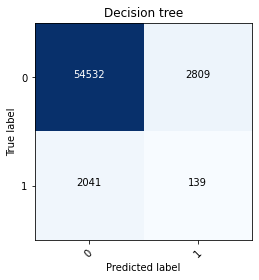

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print('Decision tree classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_tree),
              geometric_mean_score(y_test, y_pred_tree)))
cm_tree = confusion_matrix(y_test, y_pred_tree)
fig, ax = plt.subplots()
plot_confusion_matrix(cm_tree, classes=np.unique(y), ax=ax,
                      title='Decision tree')

Decision tree classifier performance:
Balanced accuracy: 0.50 - Geometric mean 0.03
[[57339     2]
 [ 2178     2]]



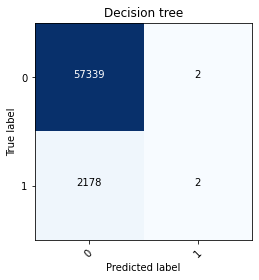

In [ ]:
# dectree is another Single Decision Tree but has max depth only at 5 in order to visualize the Tree. Therefore, it has a disadvantage to classify as well as the above default one.
dectree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
dectree.fit(X_train, y_train)
y_pred_tree = dectree.predict(X_test)
print('Decision tree classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_tree),
              geometric_mean_score(y_test, y_pred_tree)))
cm_tree = confusion_matrix(y_test, y_pred_tree)
fig, ax = plt.subplots()
plot_confusion_matrix(cm_tree, classes=np.unique(y), ax=ax,
                      title='Decision tree')

### 1.2 Mean ROC AUC

In [ ]:
# Single decision tree
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# evaluate model
train_scores_tree = cross_val_score(tree, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_tree = cross_val_score(tree, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_tree))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_tree))

Mean ROC AUC on Train Set: 0.506
Mean ROC AUC on Test Set: 0.508


In [ ]:
# Single decision tree with max_depth = 5
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
# evaluate model
train_scores_dectree = cross_val_score(dectree, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_dectree = cross_val_score(dectree, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_dectree))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_dectree))

Mean ROC AUC on Train Set: 0.603
Mean ROC AUC on Test Set: 0.584


### 1.3 Score on Train / Test Set

In [ ]:
print('Single Decision Tree score on Train Set: ' + str(tree.score(X_train, y_train)))
print('Single Decision Tree score on Test Set: ' + str(tree.score(X_test, y_test)))

Single Decision Tree score on Train Set: 1.0
Single Decision Tree score on Test Set: 0.918516153962467


In [ ]:
print('Single Decision Tree score on Train Set: ' + str(dectree.score(X_train, y_train)))
print('Single Decision Tree score on Test Set: ' + str(dectree.score(X_test, y_test)))

Single Decision Tree score on Train Set: 0.9635087542448164
Single Decision Tree score on Test Set: 0.9633742712656037


## 2. Bagging classifier with and without sampling




A number of estimators are built on various randomly selected data subsets in ensemble classifiers. But each data subset is not allowed to be balanced by Bagging classifier because the majority classes will be favored by it when implementing training on imbalanced data set.

In contrast, each data subset is allowed to be resample in ordor to have each ensemble's estimator trained by the Balanced Bagging Classifier. This means the output of an Easy Ensemble sample with an ensemble of classifiers, Bagging Classifier for instance will be combined. So an advantage of Balanced Bagging Classifier over Bagging Classifier from scikit learn is that it takes the same parameters and also another two parameters, sampling stratgy and replacement to keep the random under-sampler's behavior under control.

### 2.1 Confusion Matrix

In [ ]:
bagging = BaggingClassifier(n_estimators=10, random_state=0)
balanced_bagging = BalancedBaggingClassifier(n_estimators=10, random_state=0)

bagging.fit(X_train, y_train)
balanced_bagging.fit(X_train, y_train)

y_pred_bc = bagging.predict(X_test)
y_pred_bbc = balanced_bagging.predict(X_test)

Bagging classifier performance:
Balanced accuracy: 0.50 - Geometric mean 0.04
[[57324    17]
 [ 2177     3]]

Balanced Bagging classifier performance:
Balanced accuracy: 0.53 - Geometric mean 0.45
[[47432  9909]
 [ 1652   528]]



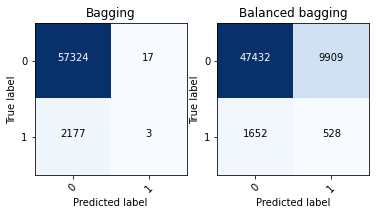

In [ ]:
# Balancing each bootstrap sample allows to increase significantly the balanced accuracy and the geometric mean.
print('Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bc),
              geometric_mean_score(y_test, y_pred_bc)))
cm_bagging = confusion_matrix(y_test, y_pred_bc)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_bagging, classes=np.unique(y), ax=ax[0],
                      title='Bagging')

print('Balanced Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bbc),
              geometric_mean_score(y_test, y_pred_bbc)))
cm_balanced_bagging = confusion_matrix(y_test, y_pred_bbc)
plot_confusion_matrix(cm_balanced_bagging, classes=np.unique(y),
                      ax=ax[1], title='Balanced bagging')

### 2.2 Mean ROC AUC 

In [ ]:
# Bagging classifier
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# Fit
#bagging.fit(X_train, y_train)
# evaluate model
train_scores_bagging = cross_val_score(bagging, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_bagging = cross_val_score(bagging, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_bagging))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_bagging))

Mean ROC AUC on Train Set: 0.537
Mean ROC AUC on Test Set: 0.539


In [ ]:
# Balanced Bagging classifier 
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# Fit
# balanced_bagging.fit(X_train, y_train)
# evaluate model
train_scores_balanced_bagging = cross_val_score(balanced_bagging, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_balanced_bagging = cross_val_score(balanced_bagging, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_balanced_bagging))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_balanced_bagging))

Mean ROC AUC on Train Set: 0.572
Mean ROC AUC on Test Set: 0.559


### 2.3 Scores on Train / Test Set

In [ ]:
print('Bagging Classifier score on Train Set: ' + str(bagging.score(X_train, y_train)))
print('Balanced Bagging Classifier score on Test Set: ' + str(balanced_bagging.score(X_test, y_test)))

Bagging Classifier score on Train Set: 0.991356010156058
Balanced Bagging Classifier score on Test Set: 0.8057660321567178


## 3. Random Forest classifier with and without sampling




Random Forest is another popular ensemble method and it is usually outperforming bagging. Here, we used a vanilla random forest and its balanced counterpart in which each bootstrap sample is balanced.

#### 3.1 Confusion Matrix

In [ ]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.7.0)


Random Forest classifier performance:
Balanced accuracy: 0.50 - Geometric mean 0.06
[[57241   100]
 [ 2173     7]]

Balanced Random Forest classifier performance:
Balanced accuracy: 0.54 - Geometric mean 0.54
[[30978 26363]
 [  994  1186]]



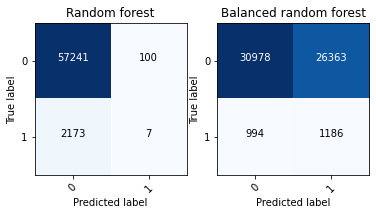

In [ ]:
rf = RandomForestClassifier(n_estimators=5, random_state=0, n_jobs=-1)
brf = BalancedRandomForestClassifier(n_estimators=5, random_state=0)

rf.fit(X_train, y_train)
brf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_brf = brf.predict(X_test)

# Similarly to the previous experiment, the balanced classifier outperform the
# classifier which learn from imbalanced bootstrap samples. In addition, random
# forest outsperforms the bagging classifier.
print('Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_rf),
              geometric_mean_score(y_test, y_pred_rf)))
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(ncols=2) # 1 
plot_confusion_matrix(cm_rf, classes=np.unique(y), ax=ax[0],
                      title='Random forest') # ax=ax

print('Balanced Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_brf),
              geometric_mean_score(y_test, y_pred_brf)))
cm_brf = confusion_matrix(y_test, y_pred_brf)
plot_confusion_matrix(cm_brf, classes=np.unique(y), ax=ax[1],
                      title='Balanced random forest')

In [ ]:
# # Random Forest with max depth = 10
# rf5 = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=5, random_state=0, n_jobs=-1)

# rf5.fit(X_train, y_train)

# y_pred_rf5 = rf5.predict(X_test)

# # Similarly to the previous experiment, the balanced classifier outperform the
# # classifier which learn from imbalanced bootstrap samples. In addition, random
# # forest outsperforms the bagging classifier.

# print('Random Forest classifier performance:')
# print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
#       .format(balanced_accuracy_score(y_test, y_pred_rf5),
#               geometric_mean_score(y_test, y_pred_rf5)))
# cm_rf5 = confusion_matrix(y_test, y_pred_rf5)
# fig, ax = plt.subplots(ncols=1)
# plot_confusion_matrix(cm_rf5, classes=np.unique(y), ax=ax,
#                       title='Random forest')

In [ ]:
# Feature Importance of Balanced Random Forest classifier
brf.feature_importances_  

array([2.22426486e-02, 1.22986973e-02, 3.16565813e-02, 8.42253781e-03,
       1.33690781e-02, 6.39540107e-03, 5.90760995e-03, 4.54524509e-03,
       5.39314646e-03, 4.05988743e-05, 1.67062949e-04, 7.05645552e-04,
       1.09419600e-04, 9.73303402e-04, 3.54388368e-02, 6.47049074e-03,
       7.98654022e-03, 4.75210008e-03, 2.38333888e-02, 2.90319203e-02,
       5.35285066e-02, 2.08451503e-02, 5.42134189e-03, 8.49827910e-03,
       8.31497590e-03, 1.14889217e-02, 2.30000820e-02, 6.42668364e-03,
       3.91503030e-03, 1.16924767e-02, 7.62248125e-04, 3.62201142e-02,
       1.19272554e-02, 2.23217600e-02, 5.80350633e-02, 4.14103303e-02,
       2.74803442e-02, 3.15125592e-02, 3.02329370e-02, 3.19958136e-02,
       2.23135201e-02, 2.39763991e-02, 2.48099645e-02, 2.49022726e-02,
       2.64794919e-02, 2.36875681e-02, 3.37112806e-02, 3.11051683e-02,
       2.19276569e-02, 2.71057364e-02, 3.33760383e-02, 5.61743158e-03,
       7.37923773e-03, 8.60607778e-03, 6.89774781e-03, 7.49640348e-03,
      

### 3.2 Mean ROC AUC

In [ ]:
# Random Forest classifier
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
train_scores_rf = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_rf = cross_val_score(rf, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_rf))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_rf))

Mean ROC AUC on Train Set: 0.523
Mean ROC AUC on Test Set: 0.521


In [ ]:
# Balanced Random Forest classifier
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
train_scores_brf = cross_val_score(brf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_brf = cross_val_score(brf, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_brf))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_brf))

Mean ROC AUC on Train Set: 0.551
Mean ROC AUC on Test Set: 0.539


### 3.3 Scores on Train / Test Set

In [ ]:
print('Random Forest classifier score on Train Set: ' + str(rf.score(X_train, y_train)))

Random Forest classifier score on Train Set: 0.9914799157442


In [ ]:
print('Balanced Random Forest classifier score on Test Set: ' + str(brf.score(X_test, y_test)))

Balanced Random Forest classifier score on Test Set: 0.5403807059693218


## 4. Boosting classifier (Easy Ensemble, RUS Boost, XGBoost)



In the same manner, Easy Ensemble classifier is a bag of balanced AdaBoost classifier. However, it will be slower to train than random forest and will achieve worse performance

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.EasyEnsembleClassifier.html

RUS Boost: Several methods taking advantage of boosting have been designed. RUSBoostClassifier randomly under-sample the dataset before to perform a boosting iteration. Random under-sampling integrating in the learning of an AdaBoost classifier. During learning, the problem of class balancing is alleviated by random under-sampling the sample at each iteration of the boosting algorithm.

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.RUSBoostClassifier.html?highlight=rusboost#imblearn.ensemble.RUSBoostClassifier

XGBoost provides a highly efficient implementation of the stochastic gradient boosting algorithm and access to a suite of model hyperparameters designed to provide control over the model training process.

https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

#### 4.1 Confusion Matrix

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Easy ensemble classifier performance:
Balanced accuracy: 0.57 - Geometric mean 0.57
[[36148 21193]
 [ 1058  1122]]



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

RUSBoost classifier performance:
Balanced accuracy: 0.59 - Geometric mean 0.58
[[35428 21913]
 [  974  1206]]



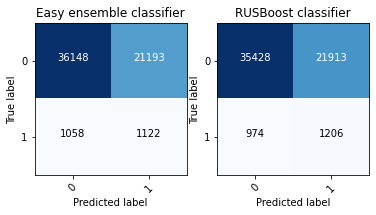

In [ ]:
base_estimator = AdaBoostClassifier(n_estimators=5)
eec = EasyEnsembleClassifier(n_estimators=5,
                             base_estimator=base_estimator)
eec.fit(X_train, y_train)
y_pred_eec = eec.predict(X_test)
print('Easy ensemble classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_eec),
              geometric_mean_score(y_test, y_pred_eec)))
cm_eec = confusion_matrix(y_test, y_pred_eec)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_eec, classes=np.unique(y), ax=ax[0],
                      title='Easy ensemble classifier')

rusboost = RUSBoostClassifier(n_estimators=10,
                              base_estimator=base_estimator)
rusboost.fit(X_train, y_train)
y_pred_rusboost = rusboost.predict(X_test)
print('RUSBoost classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_rusboost),
              geometric_mean_score(y_test, y_pred_rusboost)))
cm_rusboost = confusion_matrix(y_test, y_pred_rusboost)
plot_confusion_matrix(cm_rusboost, classes=np.unique(y),
                      ax=ax[1], title='RUSBoost classifier')

plt.show()

XGBoost Classifier performance:
Balanced accuracy: 0.50 - Geometric mean 0.03
[[57336     5]
 [ 2178     2]]



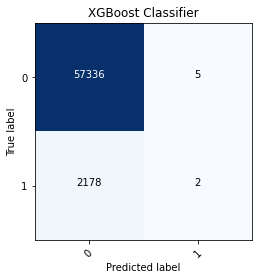

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb

xgboost = xgb.XGBClassifier(
    n_estimators=5,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=0,
    tree_method='gpu_hist'  # THE MAGICAL PARAMETER
) # n_estimators=500

xgboost.fit(X_train, y_train)

y_pred_xgboost = xgboost.predict(X_test)

# Similarly to the previous experiment, the balanced classifier outperform the
# classifier which learn from imbalanced bootstrap samples. In addition, random
# forest outsperforms the bagging classifier.

print('XGBoost Classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_xgboost),
              geometric_mean_score(y_test, y_pred_xgboost)))
cm_xgboost = confusion_matrix(y_test, y_pred_xgboost)
fig, ax = plt.subplots(ncols=1)
plot_confusion_matrix(cm_xgboost, classes=np.unique(y), ax=ax,
                      title='XGBoost Classifier')

### 4.2 Mean ROC AUC 

In [ ]:
# Easy Ensemble for imbalanced classification
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# evaluate model eec
train_scores = cross_val_score(eec, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores = cross_val_score(eec, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores))

Mean ROC AUC on Train Set: 0.608
Mean ROC AUC on Test Set: 0.603


In [ ]:
# RUS Boost
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# evaluate model rusboost
train_scores_rusboost = cross_val_score(rusboost, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_rusboost = cross_val_score(rusboost, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_rusboost))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_rusboost))

Mean ROC AUC on Train Set: 0.627
Mean ROC AUC on Test Set: 0.613


In [ ]:
# XGBoost classifier
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# evaluate model
train_scores_xgboost = cross_val_score(xgboost, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
test_scores_xgboost = cross_val_score(xgboost, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC on Train Set: %.3f' % mean(train_scores_xgboost))
print('Mean ROC AUC on Test Set: %.3f' % mean(test_scores_xgboost))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Mean ROC AUC on Train Set: 0.620
Mean ROC AUC on Test Set: 0.589


### 4.3 Scores on Train / Test Set

In [ ]:
print('Easy Ensemble Classifier score on Train Set: ' + str(eec.score(X_train, y_train)))
print('RUS Boost score on Test Set: ' + str(rusboost.score(X_test, y_test)))

Easy Ensemble Classifier score on Train Set: 0.6258828273155119
RUS Boost score on Test Set: 0.6154802506678315


In [ ]:
print('XGBoost classifier score on Test Set: ' + str(xgboost.score(X_test, y_test)))

XGBoost classifier score on Test Set: 0.9633238688866115


## 5. Create DNN Model to compare with different kinds of Trees and Forests

### 5.1 Scale data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
print(X_train_scaled.shape)

(476169, 57)


### 5.2 DNN Model

In [ ]:
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras.models import Sequential, Model
# import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization

def make_model(n_features):
    model = Sequential()
    model.add(Dense(200, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(50, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [ ]:
imblearn.show_versions()


System:
     python: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
 executable: /usr/bin/python3
    machine: Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic

Python dependencies:
        pip: 19.3.1
 setuptools: 49.2.0
   imblearn: 0.7.0
    sklearn: 0.23.2
      numpy: 1.18.5
      scipy: 1.4.1
     Cython: 0.29.21
     pandas: 1.0.5
      keras: 2.4.3
 tensorflow: 2.3.0
     joblib: 0.16.0


In [ ]:
dnn_model = make_model(X_train.shape[1])
history = dnn_model.fit(X_train_scaled, y_train, epochs=5, verbose=1, validation_data=(X_val_scaled, y_val), batch_size=1000)

Epoch 1/5
477/477 [==============================] - 4s 9ms/step - loss: 0.2694 - accuracy: 0.9227 - val_loss: 0.1579 - val_accuracy: 0.9642
Epoch 2/5
477/477 [==============================] - 4s 8ms/step - loss: 0.1618 - accuracy: 0.9632 - val_loss: 0.1528 - val_accuracy: 0.9642
Epoch 3/5
477/477 [==============================] - 4s 8ms/step - loss: 0.1597 - accuracy: 0.9633 - val_loss: 0.1517 - val_accuracy: 0.9642
Epoch 4/5
477/477 [==============================] - 4s 8ms/step - loss: 0.1586 - accuracy: 0.9633 - val_loss: 0.1516 - val_accuracy: 0.9642
Epoch 5/5
477/477 [==============================] - 4s 8ms/step - loss: 0.1579 - accuracy: 0.9634 - val_loss: 0.1514 - val_accuracy: 0.9642


In [ ]:
y_pred = dnn_model.predict(X_test, batch_size=1000)

In [ ]:
print(y_pred)

[[0.02850922]
 [0.00979213]
 [0.05552964]
 ...
 [0.00529212]
 [0.00812945]
 [0.00510255]]


In [ ]:
# input = Input(shape=X_train_scaled.shape[1:])
# dense = Dense(64, activation='relu')(input)
# dense = Dense(64, activation='relu')(dense)
# output = Dense(1, activation='sigmoid')(dense)
# dnn_model = Model(input, output)
# dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
# history = dnn_model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_val_scaled, y_val))

# C. Draw Feature Importance

Permutation Importance with Multicollinear or Correlated Features:

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

Permutation Importance vs Random Forest Feature Importance (MDI):

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

In [ ]:
import seaborn as sns
def drawFeatureImportance(model, title, n_top):
  importances = pd.DataFrame({'feature': X_train.columns,'importance':np.round(model.feature_importances_,3)})
  importances = importances.sort_values('importance', ascending=False).head(n_top)
  plt.figure(figsize=(15,5))
  sns.barplot(y=importances['feature'], x=importances['importance']).set_title(title)

## C.1. Feature Importance of Single Decision Tree

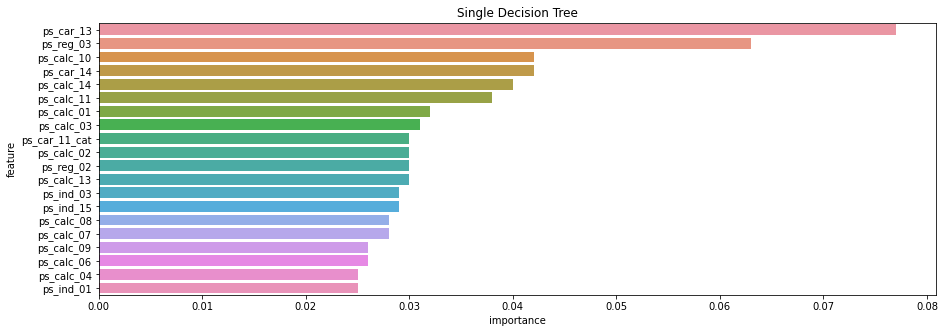

In [ ]:
drawFeatureImportance(tree, 'Single Decision Tree', 20)

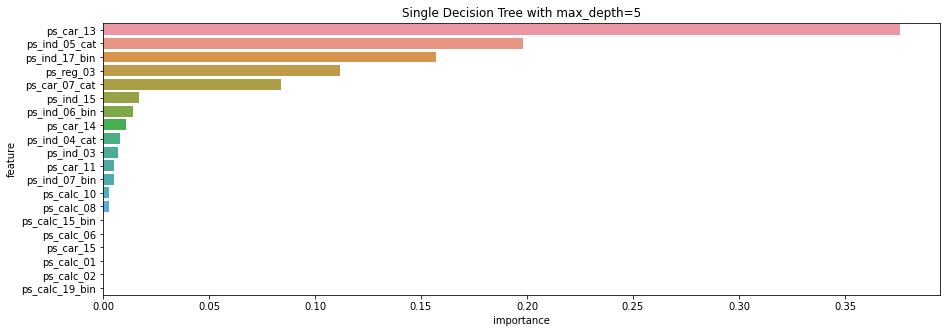

In [ ]:
drawFeatureImportance(dectree, 'Single Decision Tree with max_depth=5', 20)

There is no Feature Importance of Bagging Classifier

In [ ]:
# drawFeatureImportance(bagging, 'Bagging Classifier', 20)

There is no Feature Importance of Balanced Bagging Classifier 

In [ ]:
# drawFeatureImportance(balanced_bagging, 'Balanced Bagging Classifier', 20)

In [ ]:
# Alternative method for Balanced Bagging Classifer's Feature Importance
# brf.feature_importances_  

In [ ]:
# importance_balanced_bagging = pd.DataFrame({'feature': X_train.columns,'importance':np.round(balanced_bagging.feature_importances_,3)})
# importance_balanced_bagging = importance_balanced_bagging.sort_values('importance', ascending=False).head(20)
# sns.barplot(y=importance_balanced_bagging['feature'], x=importance_balanced_bagging['importance']).set_title('Balanced Random Forest')

## C.2. Feature Importance of Random Forest

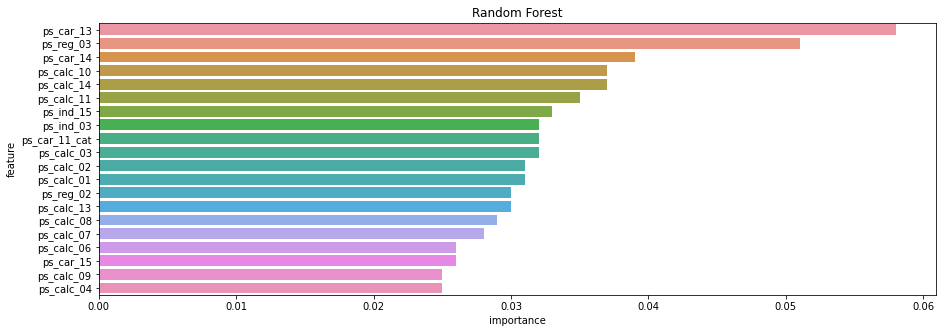

In [ ]:
drawFeatureImportance(rf, 'Random Forest', 20)

In [ ]:
# # Alternative method for Bagging Classifer's Feature Importance
# # https://machinelearningmastery.com/calculate-feature-importance-with-python/
# # https://scikit-learn.org/stable/modules/ensemble.html
# # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
# importance_rf = rf.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance_rf):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.figure(figsize=(20,10))
# plt.bar([x for x in range(len(importance_rf))], importance_rf) # thay x bằng tên cột[x], sort tên cột & sort importance by same order
# plt.show()
# print(importance_rf.dtype)

## C.3. Feature Importance of Balanced Random Forest

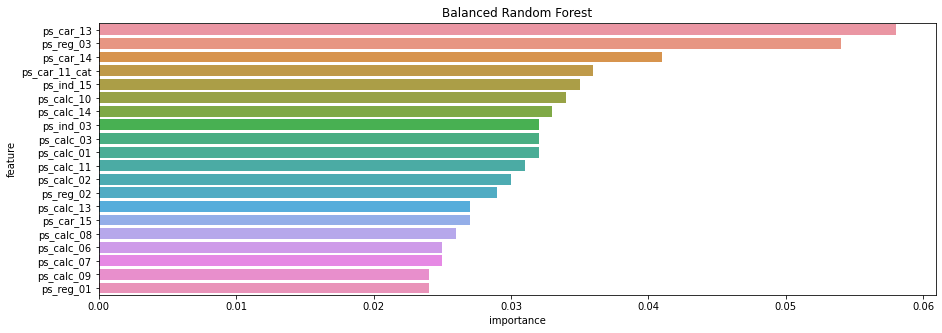

In [ ]:
drawFeatureImportance(brf, 'Balanced Random Forest', 20)

Feature Importance of Easy Ensemble Classifier

In [ ]:
# drawFeatureImportance(eec, 'Easy Ensemble Classifier', 20)

## C.4. Feature Importance of RUS Boost

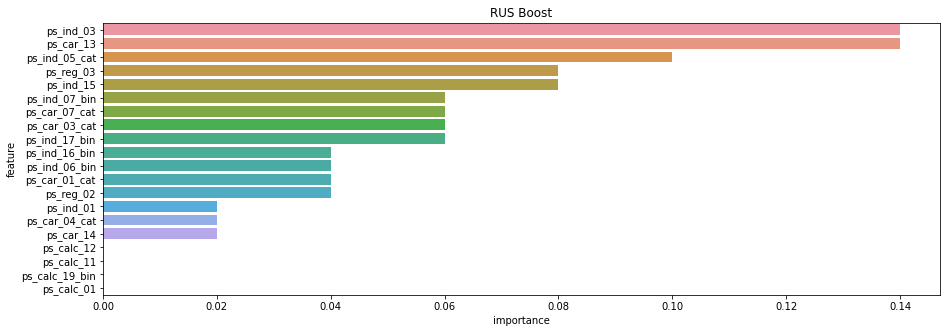

In [ ]:
drawFeatureImportance(rusboost, 'RUS Boost', 20)

## C.5. Feature Importance of XGBoost

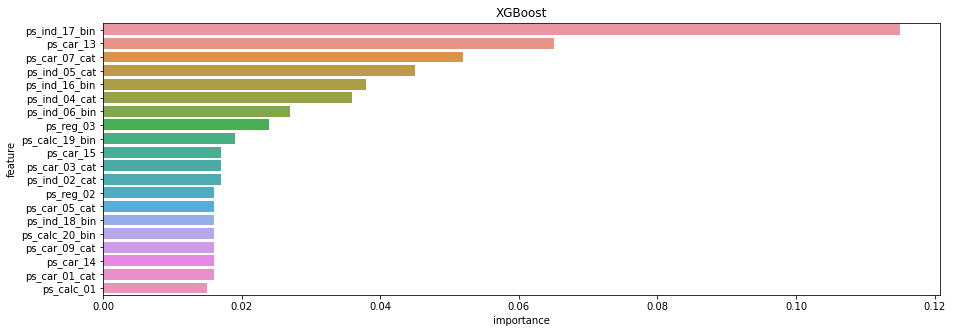

In [ ]:
drawFeatureImportance(xgboost, 'XGBoost', 20)

# D. Heatmap

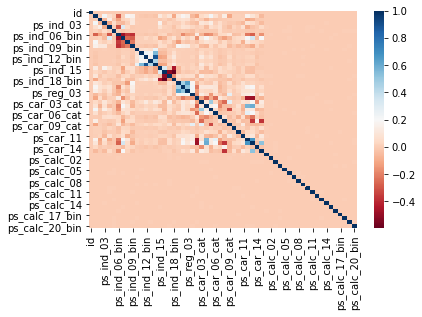

In [ ]:
sns.heatmap(df_test.corr(), cmap="RdBu")

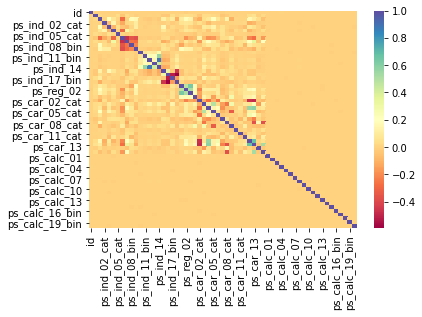

In [ ]:
sns.heatmap(df_train.corr(), cmap="Spectral")

# E. Draw Tree

In [ ]:
!pip install --upgrade scikit-learn==0.23.2

  Using cached https://files.pythonhosted.org/packages/5c/a1/273def87037a7fb010512bbc5901c31cfddfca8080bc63b42b26e3cc55b3/scikit_learn-0.23.2-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [ ]:
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# draw tree
def drawTree(model):
  dot_data = StringIO()
  export_graphviz(model, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True,
                  feature_names = iris.feature_names[2:],
                  class_names= iris.target_names
                  )
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
  return graph.create_png()

In [ ]:
print(len(rf.estimators_))

5


In [ ]:
!dot -Tpng tree.dot -o tree.png

Error: dot: can't open tree.dot


In [ ]:
# https://www.kaggle.com/hamelg/python-for-data-29-decision-trees
# https://www.kdnuggets.com/2020/04/visualizing-decision-trees-python.html
# import graphviz
# # from sklearn.externals.six import StringIO  
# from sklearn.tree import export_graphviz
# import pydotplus
# from IPython.display import Image
# dot_data = tree.export_graphviz(dectree, out_file=None) 
# graph = graphviz.Source(dot_data)  
# graph 

In [ ]:
# fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (4,4), dpi=800)
# rf.plot_tree(rf.estimators_[0],
#                feature_names = X_test, 
#                class_names=y_test,
#                filled = True);
# fig.savefig('rf_individualtree.png')

In [ ]:
# import graphviz

# # Save tree as dot file
# dot_data = rf.export_graphviz(rf, out_file=None) 
# graph = graphviz.Source(dot_data)  
# graph 

In [ ]:
# dot_data = tree.export_graphviz(tree_model, out_file=None) 
# graph = graphviz.Source(dot_data)  
# graph 

In [ ]:
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

def drawTree(model):
  dot_data = StringIO()
  export_graphviz(model, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True,
                  feature_names = X_train.columns,
                  class_names=[str(x) for x in model.classes_]
                  )
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
  return graph.create_png()

I tried other ways to visualize a large tree but since it is too large to handle, I haven't found any other solutions to draw it out so I keep the codes here.

You can move on to part E.1.

In [ ]:
# ! python -h svg -Goverlap=prism input.dot -o output.svg -v

In [ ]:
# ! python main.py --layer4 -i some.pcap -o some.svg

python3: can't open file 'main.py': [Errno 2] No such file or directory


In [ ]:
# ! sfdp -x -Goverlap=scale -Tpng tree.dot > tree.png

Error: sfdp: can't open tree.dot


In [ ]:
# ! -T svg

/bin/bash: -T: command not found


In [ ]:
# ! sfdp -o svg

In [ ]:
# # https://stackoverflow.com/questions/42621190/display-this-decision-tree-with-graphviz
# from sklearn.tree import export_graphviz
# feature_names = list(df_train.columns) 
# print(feature_names)
# feature_names.remove('id')
# feature_names.remove('target')
# classes = ['0', '1']
# print(type(classes))
# print(feature_names)
# export_graphviz(tree, out_file="tree.dot", class_names=classes,feature_names=feature_names, impurity=False, filled=True)

# import graphviz
# with open("tree.dot") as f:
#     dot_graph = f.read()
# g = graphviz.Source(dot_graph)
# g.render()
# g.view()

['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
<class 'list'>
['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_i

KeyboardInterrupt: ignored

In [ ]:
# g.view()

In [ ]:
# g.format = "png"
# g.render("decision_tree")

## E.1 Tree of Single Decision Tree

tree is too deep in terms of max depth while dectree has max_depth of only 5 so we can draw the Single Decision tree map.

In [ ]:
Image(drawTree(tree))

KeyboardInterrupt: ignored

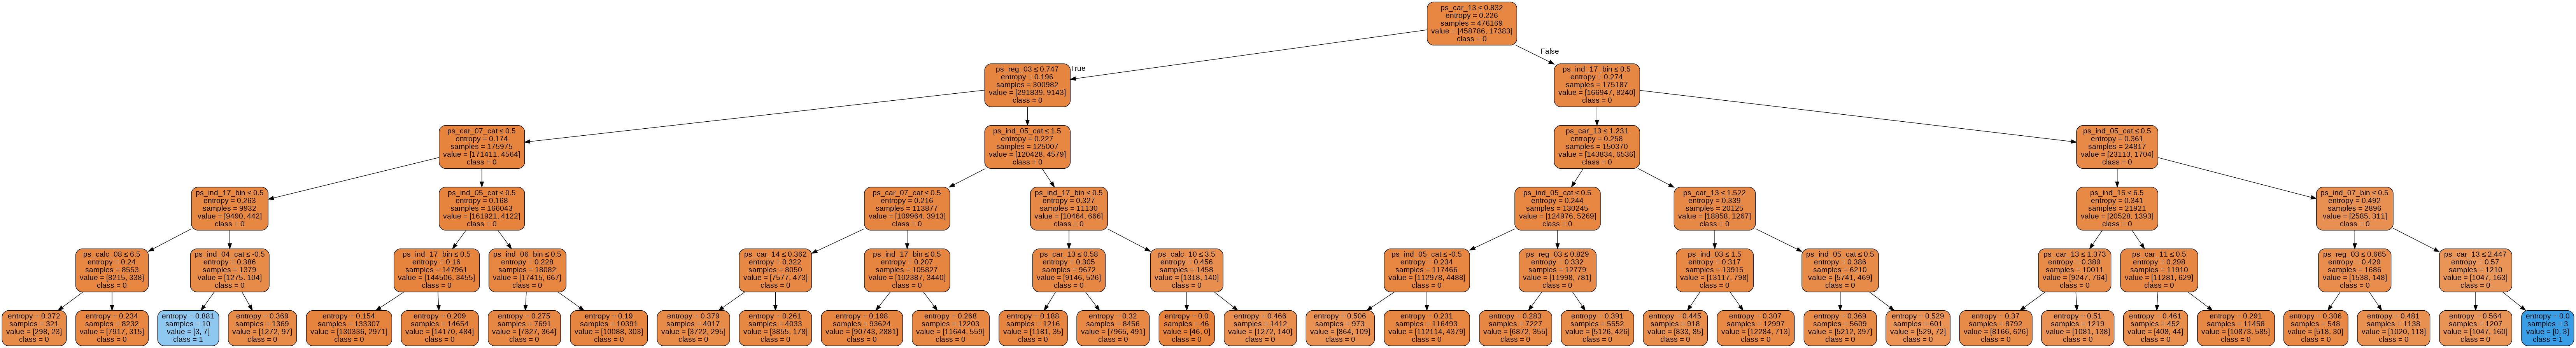

In [ ]:
Image(drawTree(dectree))

Tree of Bagging Classifier

In [ ]:
# Image(drawTree(bagging))

Tree of Balanced Bagging Classifier

In [ ]:
# Image(drawTree(balanced_bagging))

Tree of Random Forest

In [ ]:
Image(drawTree(rf))

In [ ]:
# Image(drawTree(rf5))

In [ ]:
# Image(drawTree(rf.estimators_[1]))

Tree of Balanced Random Forest

In [ ]:
Image(drawTree(brf))

Tree of Easy Ensemble

In [ ]:
# Image(drawTree(eec))

Tree of RUS Boost

In [ ]:
# Image(drawTree(rusboost))

Tree of XGBoost

In [ ]:
# Image(drawTree(xgboost))

# F. ROC & AUC between MLP-DNN, Trees, Forests, Boosts

In [ ]:
# ROC & AUC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# pred_proba = model.predict_proba(X_val)
# print('AUC: ' + str(roc_auc_score(y_val, pred_proba[:,1])))

# Probs:
nomodel_probs = [0 for _ in range(len(y_val))]

mlp_probs = dnn_model.predict(X_val_scaled)[:, 0]

decisiontree_probs = tree.predict_proba(X_val)[:, 1]
bagging_probs = bagging.predict_proba(X_val)[:, 1]
balanced_bagging_probs = balanced_bagging.predict_proba(X_val)[:, 1]
randomforest_probs = rf.predict_proba(X_val)[:, 1]
balanced_randomforest_probs = brf.predict_proba(X_val)[:, 1]
xgboost_probs = xgboost.predict_proba(X_val)[:, 1]
eec_probs = eec.predict_proba(X_val)[:, 1]
rusboost_probs = rusboost.predict_proba(X_val)[:, 1]

best_probs = [x for x in y_val]

# AUC: 
nomodel_auc = roc_auc_score(y_val, nomodel_probs)
mlp_auc = roc_auc_score(y_val, mlp_probs)

decisiontree_auc = roc_auc_score(y_val, decisiontree_probs)
bagging_auc = roc_auc_score(y_val, bagging_probs)
balanced_bagging_auc = roc_auc_score(y_val, balanced_bagging_probs)
randomforest_auc = roc_auc_score(y_val, randomforest_probs)
balanced_randomforest_auc = roc_auc_score(y_val, balanced_randomforest_probs)
eec_auc = roc_auc_score(y_val, eec_probs)
rusboost_auc = roc_auc_score(y_val, rusboost_probs)
xgboost_auc = roc_auc_score(y_val, xgboost_probs)
best_auc = roc_auc_score(y_val, best_probs)

# Summarize scores:
print('No Skill: ROC AUC=%.3f' % (nomodel_auc))
print('With MLP: ROC AUC=%.3f' % (mlp_auc))
print('With Decision Tree: ROC AUC=%.3f' % (decisiontree_auc))
print('With Bagging: ROC AUC=%.3f' % (bagging_auc))
print('With Balanced Bagging: ROC AUC=%.3f' % (balanced_bagging_auc))
print('With Random Forest: ROC AUC=%.3f' % (randomforest_auc))
print('With Balanced Random Forest: ROC AUC=%.3f' % (balanced_randomforest_auc))
print('With Easy Ensemble: ROC AUC=%.3f' % (eec_auc))
print('With RUS Boost: ROC AUC=%.3f' % (rusboost_auc))
print('With XGBoost: ROC AUC=%.3f' % (xgboost_auc))
print('Best: ROC AUC=%.3f' % (best_auc))

No Skill: ROC AUC=0.500
With MLP: ROC AUC=0.621
With Decision Tree: ROC AUC=0.503
With Bagging: ROC AUC=0.535
With Balanced Bagging: ROC AUC=0.560
With Random Forest: ROC AUC=0.521
With Balanced Random Forest: ROC AUC=0.549
With Easy Ensemble: ROC AUC=0.612
With RUS Boost: ROC AUC=0.624
With XGBoost: ROC AUC=0.609
Best: ROC AUC=1.000


RUS Boost is the best classifers for this imbalanced dataset since its ROC AUC reaches the highest score at 0.624.

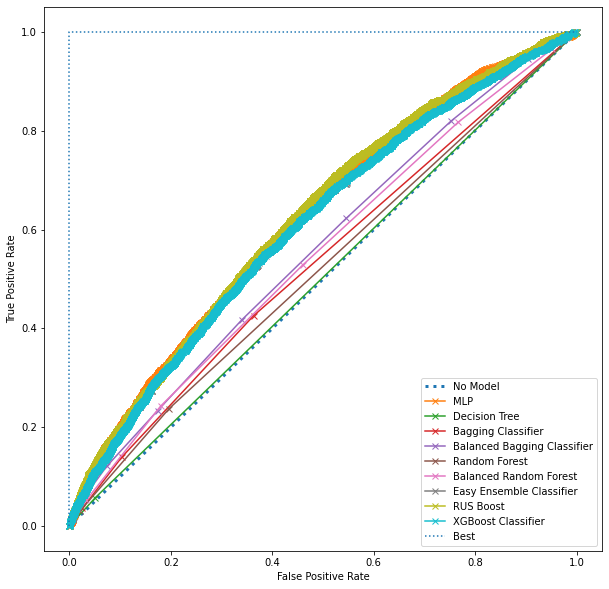

In [ ]:
# Calculate ROC Curves
nomodel_fpr, nomodel_tpr, _ = roc_curve(y_val, nomodel_probs)
mlp_fpr, mlp_tpr, _ = roc_curve(y_val, mlp_probs)
decisiontree_fpr, decisiontree_tpr, _ = roc_curve(y_val, decisiontree_probs)
bagging_fpr, bagging_tpr, _ = roc_curve(y_val, bagging_probs)
balanced_bagging_fpr, balanced_bagging_tpr, _ = roc_curve(y_val, balanced_bagging_probs)
randomforest_fpr, randomforest_tpr, _ = roc_curve(y_val, randomforest_probs)
balanced_randomforest_fpr, balanced_randomforest_tpr, _ = roc_curve(y_val, balanced_randomforest_probs)
eec_fpr, eec_tpr, _ = roc_curve(y_val, eec_probs)
rusboost_fpr, rusboost_tpr, _ = roc_curve(y_val, rusboost_probs)
xgboost_fpr, xgboost_tpr, _ = roc_curve(y_val, xgboost_probs)
best_fpr, best_tpr, _ = roc_curve(y_val, best_probs)

plt.figure(figsize=(10,10))
# plot the roc curve for the model
plt.plot(nomodel_fpr, nomodel_tpr, linestyle=':',linewidth=3, label='No Model')

plt.plot(mlp_fpr, mlp_tpr, marker='x', label='MLP')
plt.plot(decisiontree_fpr, decisiontree_tpr, marker='x', label='Decision Tree')
plt.plot(bagging_fpr, bagging_tpr, marker='x', label='Bagging Classifier')
plt.plot(balanced_bagging_fpr, balanced_bagging_tpr, marker='x', label='Balanced Bagging Classifier')
plt.plot(randomforest_fpr, randomforest_tpr, marker='x', label='Random Forest')
plt.plot(balanced_randomforest_fpr, balanced_randomforest_tpr, marker='x', label='Balanced Random Forest')
plt.plot(eec_fpr, eec_tpr, marker='x', label='Easy Ensemble Classifier')
plt.plot(rusboost_fpr, rusboost_tpr, marker='x', label='RUS Boost')
plt.plot(xgboost_fpr, xgboost_tpr, marker='x', label='XGBoost Classifier')
plt.plot(best_fpr, best_tpr, linestyle=':', label='Best')

# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show the legend
plt.legend()

# Show the plot
plt.show()

# G. Predict

In [ ]:
df_test_pred = df_test.set_index('id')

In [ ]:
# Từ model tính predict sẽ ra 0 1
predict = rusboost.predict(df_test_pred)
predict

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
predict = pd.DataFrame({'id':df_test_pred.index,'target':predict})
predict.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1


In [ ]:
predict = predict.merge(df_test_pred,on='id')
predict.head(3)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,0,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0


# H. New Policy on Trial

## H.1 List out

In [ ]:
predict[predict['target'] == 1].shape

(346723, 59)

In [ ]:
new_policy = predict.copy(True)
new_policy = new_policy.drop(columns=['target'])
new_policy = new_policy.drop(columns=['id'])

## H.2 Implement that New Policy

In [ ]:
print('ps_car_13 unique values: ', df_train['ps_car_13'].unique())

ps_car_13 unique values:  [0.88367892 0.61881652 0.64158572 ... 1.58527574 0.96169455 1.56191797]


In [ ]:
# X_policy['MonthlyIncome'] = X_policy['MonthlyIncome']*1.1 
# new_policy['OverTime_No'] = 1
# new_policy['OverTime_Yes'] = 0
# Đổi OT sang ngược lại rồi test model

new_policy['ps_car_13'] = 2.5

In [ ]:
result = dectree.predict(new_policy)

In [ ]:
len(np.where(result==1)[0])

30537

In [ ]:
new_policy['ps_car_13'] = 0.5

In [ ]:
result = brf.predict(new_policy)
len(np.where(result==1)[0])

511884

In [ ]:
new_policy['ps_car_13'] = 1
result = brf.predict(new_policy)
len(np.where(result==1)[0])

556283

In [ ]:
new_policy['ps_car_13'] = 0
result = brf.predict(new_policy)
len(np.where(result==1)[0])

491936

In [ ]:
new_policy['ps_car_13'] = -1
result = brf.predict(new_policy)
len(np.where(result==1)[0])

491936

## H.3 Result

30537 drivers will claim insurance instead of 3 with entropy = 0 when changing ps_car_13 (most influential feature by Single Decision Tree with max_depth=5) to 2.5 for example (as long as greater than 2.447). 